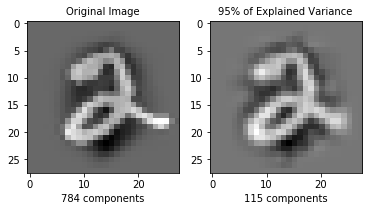

In [9]:
# 1. Image deskew: https://fsix.github.io/mnist/Deskewing.html

import timeit
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from scipy.ndimage import interpolation
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.linalg import svd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# It is very natural that every person has different handwriting which poses 
#several challenge to machine. One of the challenge is change in orientation is of each digit. 
#This can led to misclassification of a digit. Therefore, we need deskewd each digit to improve the classification.

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix


def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

# Start the time to capture runtime
start = timeit.default_timer()

# Read the training data
data = np.genfromtxt("/Users/shrilekha/Downloads/mnist_train.txt", delimiter=',')
label = data[:,0]
pixel = data[:,1:]

# Deskew the  training data data 
Deskewed_training_data =  deskewAll(pixel)

# Center the training data. Centering before PCA will help. 
center = preprocessing.StandardScaler(with_std=False).fit(Deskewed_training_data)
train_X = center.transform(Deskewed_training_data)

# Applying PCA to training data-set. This has reduced the data without loosing 95 % variance of the data.

pca = PCA(0.95)
pca = pca.fit(train_X)
reduced_data = pca.fit_transform(train_X) 
approximation = pca.inverse_transform(reduced_data)

# Comparing the image before and after reduced dimension. As we can see that there reduced dataset is not 
# loosing more information about the image and gives equiavlent to that of original dataset. In this way, we are 
# saving our computational time.

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(train_X[5].reshape(28,28),
              cmap = plt.cm.gray,interpolation='nearest')
plt.xlabel('784 components', fontsize = 10)
plt.title('Original Image', fontsize = 10);

# 115 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[5].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest');
plt.xlabel('115 components', fontsize = 10)
plt.title('95% of Explained Variance', fontsize = 10);




In [ ]:
# Read the test data
data_2 = np.genfromtxt("/Users/shrilekha/Downloads/mnist_test.txt", delimiter=',')

# Deskweing test data
Deskewed_test_data = deskewAll(data_2[:,1:])

# Centering test data
center_test = preprocessing.StandardScaler(with_std=False).fit(Deskewed_test_data)
test_X = center.transform(Deskewed_test_data)

# PCA tranformation
reduced_test_data = pca.transform(test_X)

In [12]:
print(np.shape(reduced_test_data))
print(np.shape(reduced_data ))

(10000, 115)
(60000, 115)


[5. 0. 4. ... 5. 6. 8.]


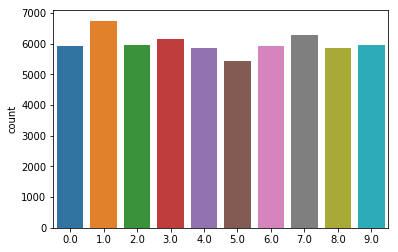

In [2]:
# This shows the frequency of each digit (0-9) in the dataset. We can say that this dataset is almost balanced. 
print(label)
import seaborn as sns
sns.countplot(label)

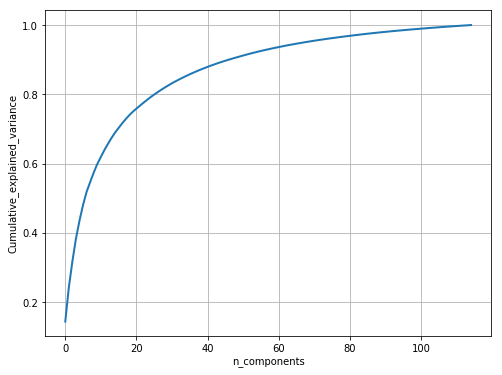

In [3]:
# Let's back to PCA. The plot below shows the percentage of variance explained versus number of features. 

pca.n_components = 784
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

plt.figure(1, figsize=(8, 6))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

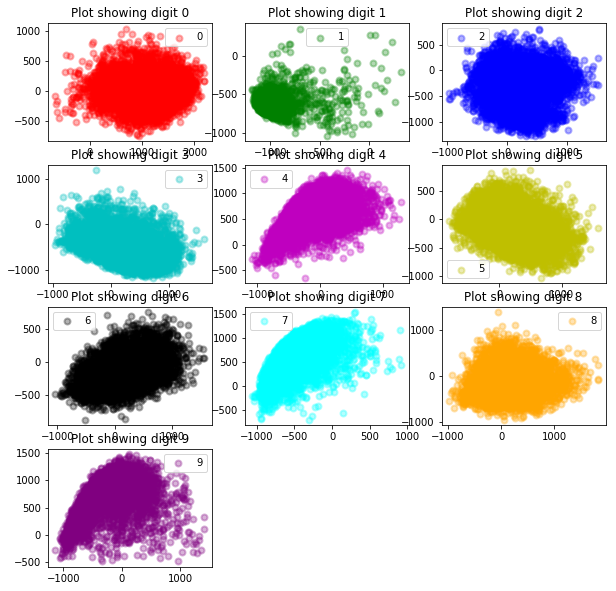

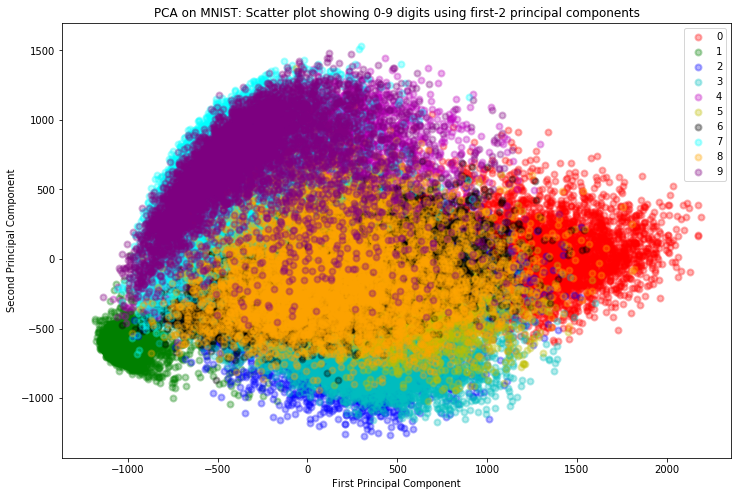

In [4]:
# Visualize PCA
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'cyan', 'orange', 'purple'
target_names = [str(i) for i in range(10)]
lw = 2

# Visualizing Classwise PCA

# PCA 95%
plt.figure(figsize=(10, 10))
# .subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(10):
    plt.subplot(4, 3, i + 1)
    plt.scatter(reduced_data[label == i, 0], reduced_data[label == i, 1], color=colors[i], alpha=.3, lw=lw,
                label=target_names[i])
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('Plot showing digit %s'%(i))

plt.show()

# PCA can be used for dimension reduction as well for data vizualization. As we can see, PCA does not helped much to
# vizualize the data. All the digits are overlapping each other.

# PCA 95%
plt.figure(figsize=(12, 8))
for color, i, target_name in zip(colors, [i for i in range(10)], target_names):
    plt.scatter(reduced_data[label == i, 0], reduced_data[label == i, 1], color=color, alpha=.3, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA on MNIST: Scatter plot showing 0-9 digits using first-2 principal components')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()


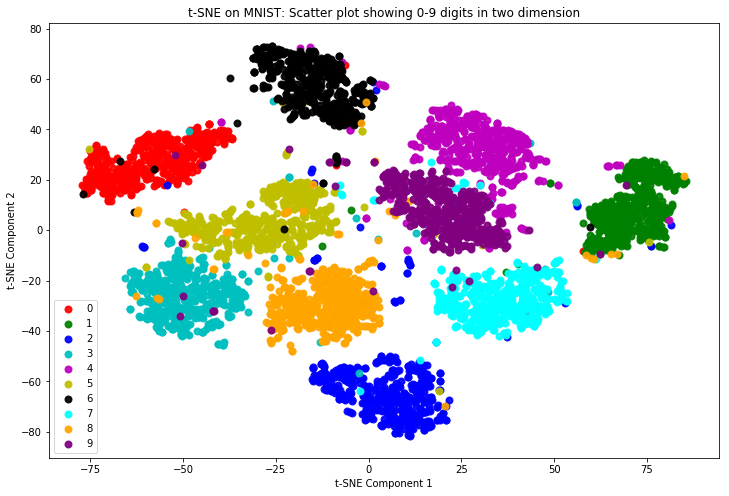

In [7]:

#To better visualize the high dimensional digit data set I used the algorithm, namely, t-SNE.
#It helps to visualize the high dimensional data in 2-D or 3-D. You can find more about this algorithm at 
#http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf


# Perform t-SNE on dataset with 50 dimension and with 5000 rows
digit_r=500
d0=reduced_data[label==0][:digit_r]
d1=reduced_data[label==1][:digit_r]
d2=reduced_data[label==2][:digit_r]
d3=reduced_data[label==3][:digit_r]
d4=reduced_data[label==4][:digit_r]
d5=reduced_data[label==5][:digit_r]
d6=reduced_data[label==6][:digit_r]
d7=reduced_data[label==7][:digit_r]
d8=reduced_data[label==8][:digit_r]
d9=reduced_data[label==9][:digit_r]

tsne_data = np.concatenate((d0, d1, d2, d3, d4, d5, d6, d7, d8, d9), axis=0)

# Fit and transform with a TSNE
tsne = TSNE(n_components=2, random_state=0)

# Project the reduced data in 2D
X_2d = tsne.fit_transform(tsne_data)

# Vizualize t-SNE
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'cyan', 'orange', 'purple'
target_names = [str(i) for i in range(10)]
lw = 2

label_tsne=np.concatenate((np.full((500), 0), np.full((500), 1), np.full((500), 2), np.full((500), 3)
                          ,np.full((500), 4), np.full((500), 5), np.full((500), 6), np.full((500), 7)
                          ,np.full((500), 8), np.full((500), 9)))

plt.figure(figsize=(12, 8))
for color, i, target_name in zip(colors, [i for i in range(10)], target_names):
    plt.scatter(X_2d[label_tsne == i, 0], X_2d[label_tsne == i, 1], color=color, alpha=.9, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('t-SNE on MNIST: Scatter plot showing 0-9 digits in two dimension')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

